# Measuring Efficiency

In this notebook, we're going to start to measure the "efficiency" of algorithms.

"Efficiency" can mean different things in different circumstances. 
In particular, we are concerned with *how much time* algorithms take to complete their tasks.
All else being equal, if we have two algorithms, we prefer the one that takes less time.
We are also generally concerned about how long the algorithms take when working on large datasets; an algorithm that is fast for small lists but slow for large datasets usually isn't desirable.

To measure time, we import the `time` module, then use a clock.
Ordinarily, a clock measures time elapsed in the real world, since some "zero point".  For example, `time.time()` returns the number of seconds elapsed since 0:00 on January 1st, 1970.

For our purposes, we don't care about time in the real world; we care instead about how much time our program has used.  So `time.time()` is not what we want.  Instead we will `time.process_time()`, which is a clock that measures how long our process has kept the computer busy since it started running. 

To measure the time that some code, we record `time.process_time()` in a variable, run the code, then run `time.process_time()` again, and compute the difference.  Here is a function that measures how long a `Callable` runs on lists of different sizes.

In [2]:
import time
from typing import *

def measure_time_list(function: Callable, ns: List[int]) -> List[float]:
    """Run function on lists of each length in ns, and measure how long each call takes."""

    times = []
    
    for n in ns:
        testlist = list(range(n)) # make a (sorted) list of length n.
        starttime = time.process_time()
        function(testlist)
        endtime = time.process_time()
        times.append(endtime - starttime)
            
    return times

In order to analyse our measurements, we will take these measurements, plot them, and attempt to fit a curve.  This function is designed to fit either a polynomial or an exponential curve.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
        
def estimate_fit(times: List[float], ns: List[int], deg: int=0) -> List[float]:
    """Here ns is a list of problem sized, and times are the corresponding running times.
    Draw a plot of the running time (in seconds), and fit a curve:
    * if deg==0, fit an exponential curve;
    * otherwise, fit a polynomial of that degree.
    
    Requires: times and ns have the same length.
    """

    ns = np.array(ns)
    times = np.array(times)

    plt.plot(ns, times, label="Running Time")
    
    if deg == 0:
        ## Linear best-fit assuming it's an exponential function.
        pfit = np.polynomial.Polynomial.fit(ns, np.log(times), 1, w = np.sqrt(ns)).convert().coef
        pfit = np.exp(pfit)
        print("Running time is something like {:0.3} * {:0.3}**n seconds".format(pfit[0], pfit[1]))
        plt.plot(ns, pfit[0] * pfit[1] ** ns, label="Fit (Exponential)".format(deg))
    else:
        pfit = np.polynomial.Polynomial.fit(ns, times, deg)
        coefs = pfit.convert().coef
        print("Running time is something like {} seconds".format(' + '.join(['{:0.3} * x**{}'.format(coefs[i], i) 
                                                                       for i in range(deg, 1, -1)]
                                                                    + ['{:0.3} * x'.format(coefs[1]),
                                                                     '{:0.3}'.format(coefs[0])])))
        plt.plot(ns, pfit(ns), label="Fit (degree={})".format(deg))
        
    plt.xlabel("Length of list")
    plt.ylabel("Time (s)")
    plt.legend()

    plt.show()
    
    return pfit

## Example: largest item in a list
As an example, we will define several functions to calculate the largest value in a list of numbers.  

To demonstrate the cost of algorithms, consider the following description of an algorithm to find the largest item in a list:

1. If the list has only 1 item in it, return that item.
1. If the first item in the list is larger than the largest item after the first, return the first item.
1. Otherwise, return the largest item after the first item.

Below we define a function that naively implements this description.
We then measure its running time for various lists, and plot it.

The plot looks exponential, so here we fit an exponential to it:

Running time is something like 3.31e-06 * 1.71**n seconds


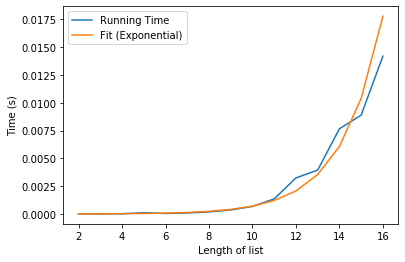

In [5]:
def largest(numbers: List[int]) -> int:
    """Return the largest value in numbers."""

    ## If the list has only 1 item, return it.
    if len(numbers) == 1:
        return numbers[0]

    ## If the first item is larger than the largest after the first, 
    ##     return the first item.
    elif numbers[0] > largest(numbers[1:]):
        return numbers[0]

    ## Otherwise, return the largest item after the first item.
    else:
        return largest(numbers[1:])        


## Now that the function is defined, test it and find a best-fit.
sizes = range(2,17)
estimate_fit(measure_time_list(largest, sizes), sizes, deg=0);

Right now, the system runs on a list of length 16 in well under 0.05 s.  That doesn't *seem* too slow.  But imagine if $n$ was a larger number — even something like 50.

Here's a second function that does the same thing, but works in a different way.  It manages to run enormously faster:

Running time is something like 5.07e-09 * x**2 + -1.78e-06 * x + 0.000216 seconds


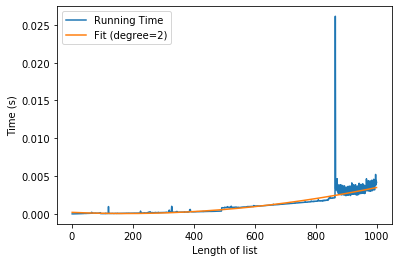

In [6]:
def largest2(numbers: List[int]) -> int:
    """Return the largest value in numbers."""
    
    ## If the list has only 1 item, return it.
    if len(numbers) == 1:
        return numbers[0]
    
    rest_largest = largest2(numbers[1:])

    ## If the first item is larger than the largest after the first, 
    ##     return the first item.
    if numbers[0] > rest_largest:
        return numbers[0]

    ## Otherwise, return the largest item after the first item.
    else:
        return rest_largest
    
sizes = range(2,1000)
estimate_fit(measure_time_list(largest2, sizes), sizes, deg=2);

This algorithm seems to run in time proportional to $n^2$; a quadratic.

You may notice that *sometimes*, for no apparent reason, it takes quite a bit longer than usual, causing "spikes" in the running time.  This has to do with internal details of how Python works.  The spikes are small enough, and rare enough, that they don't matter for our purposes.

This algorith is enormously faster than the earlier one; in just 1 s, it should be able to find the largest in a list of $10\,000$ items — a big improvement.

Can we do better?  Here's a third implementation.

Running time is something like 2.37e-08 * x + 1.28e-05 seconds


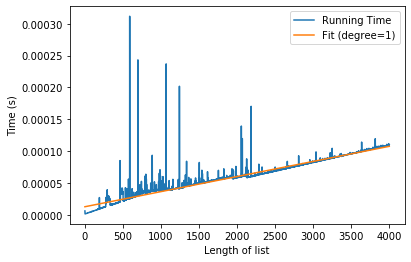

In [18]:
def largest3(numbers: List[int]) -> int:
    """Return the largest value in numbers."""
    
    largest = numbers[0]
    
    for item in numbers:
        if item > largest:
            largest = item
            
    return largest

sizes = range(2,4000)
estimate_fit(measure_time_list(largest3, sizes), sizes, deg=1);

This again is enormously better than the previous algorithm.  It seems to be run in time proportional to $n$; it's linear.

In just 1 s, this one should be able to find the largest value in a list of length around $20\,000\,000$.